In [307]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [308]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22158 entries, 0 to 22157
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22158 non-null  object 
 1   description               22158 non-null  object 
 2   summary                   22157 non-null  object 
 3   installs                  22158 non-null  object 
 4   minInstalls               22158 non-null  float64
 5   score                     22158 non-null  float64
 6   ratings                   22158 non-null  float64
 7   reviews                   22158 non-null  float64
 8   histogram                 22158 non-null  object 
 9   price                     22158 non-null  float64
 10  free                      22158 non-null  int64  
 11  currency                  22158 non-null  object 
 12  sale                      22158 non-null  bool   
 13  offersIAP                 22158 non-null  bool   
 14  inAppP

In [309]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [310]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [311]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [312]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

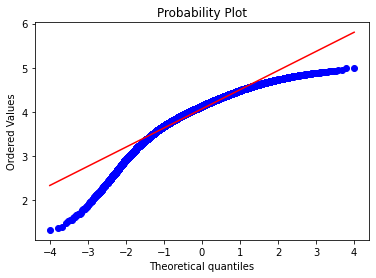

In [313]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22158
- Mean of distribution of rating : 4.068657300252703
- Standard deviation: 0.449417053871379


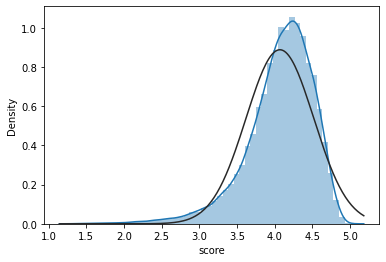

In [314]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

In [315]:
df.groupby('year')['score'].min()

year
2010    1.809032
2011    1.626476
2012    1.652318
2013    1.324779
2014    1.541436
2015    1.492308
2016    1.589474
2017    1.628866
2018    1.851852
2019    1.696825
2020    1.402204
Name: score, dtype: float64

In [316]:
df.groupby('year')['year'].count()

year
2010     343
2011     863
2012    1155
2013    1488
2014    2244
2015    2425
2016    2835
2017    3325
2018    3078
2019    2986
2020    1416
Name: year, dtype: int64

## Testing with pipeline

In [317]:
## Define pipeline transformers 

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',sparse='false'))])

In [318]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [319]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])

In [320]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse='false'))]),
                                                  Index(['genre', 'contentRating'], dtype='object'))])),
                ('linear', LinearRegression())])

In [321]:
y_pred = lr.predict(X_val)

In [322]:
lr.score(X_val,y_val)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.42
MSE of linear regression on val set: 0.34
MAE of linear regression on val set: 0.51


In [323]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val.columns, lr['linear'].coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.10
free : 0.01
containsAds : 0.00
genre : 0.00
editorsChoice : -0.02
contentRating : 0.09
year : 0.01
top_developer : -0.02
installs_day : 0.02
updated_days : 0.21
has_video : -0.12
compound : -0.00


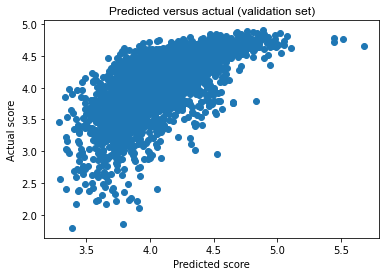

In [324]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

In [393]:
y_pred_test = lr.predict(X_test)

In [395]:
lr.score(X_test,y_test)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_test, y_test)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.40
MSE of linear regression on val set: 0.35
MAE of linear regression on val set: 0.50


## No pipeline

In [325]:
X_train_cont = X_train[['free','containsAds','editorsChoice','year','top_developer','has_video','compound']]
X_val_cont = X_val[['free','containsAds','editorsChoice','year','top_developer','has_video','compound']]

In [326]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [327]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [328]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [329]:
lr2 = LinearRegression()

lr2.fit(combo_train_df, y_train)

y_pred = lr2.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.35
MAE of linear regression on val set: 0.52


In [330]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : -0.01
editorsChoice : 0.15
year : -0.00
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.11
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.12
genre_Books & Reference : 0.11
genre_Business : 0.15
genre_Card : 0.21
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.03
genre_Dating : -0.00
genre_Education : 0.01
genre_Entertainment : -0.07
genre_Events : -0.06
genre_Finance : 0.15
genre_Food & Drink : 0.20
genre_Health & Fitness : 0.12
genre_House & Home : 0.08
genre_Libraries & Demo : 0.01
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.13
genre_Medical : -0.02
genre_Music : -0.03
genre_Music & Audio : 0.05
genre_News & Magazines : 0.05
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.08
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0

In [336]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr2.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [337]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [338]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
10136,17466.0,1,1,Lifestyle,0,Everyone,2010,0,265.816055,362,0,0.023662,1.850772,3.754417,1.903645
19530,3864.0,1,0,Sports,0,Teen,2015,0,490.436488,30,1,0.189173,2.216495,3.978695,1.762200
1321,22315.0,1,1,Lifestyle,0,Everyone,2010,0,266.311585,75,0,0.106293,2.106250,3.850345,1.744095
10562,6694.0,1,0,Tools,0,Everyone,2012,0,331.785003,507,0,0.073192,2.231689,3.874279,1.642590
7644,6727.0,1,1,Entertainment,0,Everyone,2014,0,389.559797,15,0,-0.223204,1.794643,3.384189,1.589546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19303,80941.0,1,1,Strategy,0,Everyone,2017,0,731.528895,426,1,0.086759,4.742094,3.952271,-0.789823
9226,6026.0,1,0,Social,0,Mature 17+,2020,0,5376.344086,33,0,-0.074129,4.465190,3.671325,-0.793865
17090,36384.0,1,0,Productivity,0,Everyone,2018,0,1153.402537,26,1,0.032412,4.697826,3.895562,-0.802264
3008,7382.0,1,1,News & Magazines,0,Everyone,2013,0,352.360817,14,0,0.053026,4.630582,3.821385,-0.809197


In [339]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [340]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
count,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,11145.626667,1.0,0.778333,0.008333,2016.101667,0.021667,941.636286,393.420000,0.296667,0.220877,3.408364,4.003360,0.594996
std,13193.504719,0.0,0.415715,0.090982,2.600500,0.145714,871.147800,529.513309,0.457169,0.249089,0.454639,0.315362,0.275985
min,1083.000000,1.0,0.000000,0.000000,2010.000000,0.000000,247.892910,0.000000,0.000000,-0.296930,1.794643,3.294944,0.304984
25%,3890.000000,1.0,1.000000,0.000000,2014.000000,0.000000,426.848920,60.250000,0.000000,0.035265,3.157894,3.789015,0.389373
50%,6720.000000,1.0,1.000000,0.000000,2016.500000,0.000000,656.385095,191.000000,0.000000,0.173349,3.435766,3.948971,0.509839
75%,13482.250000,1.0,1.000000,0.000000,2018.000000,0.000000,1138.952164,544.000000,1.000000,0.374339,3.712159,4.181034,0.726541
max,97197.000000,1.0,1.000000,1.000000,2020.000000,1.000000,6993.006993,3793.000000,1.000000,0.879727,4.704839,5.130268,1.903645


In [341]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,19358.076125,0.997693,0.820069,0.008074,2016.161476,0.084198,943.521236,373.813149,0.374856,0.281491,4.122296,4.118636,-0.003660
std,27747.000689,0.048001,0.384352,0.089543,2.514483,0.277845,854.571268,536.542207,0.484365,0.167122,0.285195,0.280173,0.056801
min,1064.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.708695,0.000000,0.000000,-0.304933,3.310981,3.371253,-0.099995
25%,5328.500000,1.000000,1.000000,0.000000,2014.000000,0.000000,433.839806,38.000000,0.000000,0.169090,3.937104,3.925128,-0.050485
50%,10957.000000,1.000000,1.000000,0.000000,2017.000000,0.000000,683.060109,153.000000,0.000000,0.296332,4.097222,4.099823,-0.004948
75%,21552.000000,1.000000,1.000000,0.000000,2018.000000,0.000000,1104.365261,473.500000,1.000000,0.386727,4.287435,4.264983,0.044744
max,362672.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,10000.000000,3522.000000,1.000000,0.841382,4.902087,4.946091,0.099989


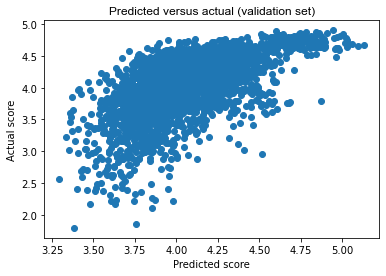

In [342]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

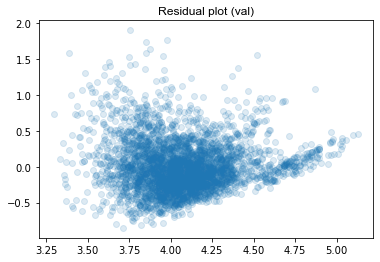

In [343]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

In [325]:
X_test_cont = X_test[['free','containsAds','editorsChoice','year','top_developer','has_video','compound']]

In [396]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [328]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [397]:
y_pred_test = lr2.predict(combo_test_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_test_df, y_test)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: -2149040.73
MSE of linear regression on val set: 657.50
MAE of linear regression on val set: 20.23


In [344]:
X_train.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound
count,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000,14180.000000
mean,21269.917630,0.995980,0.813822,0.006276,2016.073343,0.058886,945.624037,376.475670,0.333780,0.258542
std,30608.139115,0.063276,0.389264,0.078978,2.531775,0.235419,922.276024,523.056756,0.471579,0.181382
min,1000.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,246.730817,0.000000,0.000000,-0.409991
25%,5454.500000,1.000000,1.000000,0.000000,2014.000000,0.000000,426.621160,35.000000,0.000000,0.138288
50%,11359.500000,1.000000,1.000000,0.000000,2016.000000,0.000000,642.260758,159.000000,0.000000,0.258576
75%,24748.250000,1.000000,1.000000,0.000000,2018.000000,0.000000,1070.663812,496.000000,1.000000,0.370442
max,763222.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,15384.615385,3850.000000,1.000000,0.910872


In [345]:
X_val.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound
count,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000
mean,21573.245347,0.998872,0.803440,0.009024,2016.103497,0.053582,962.649287,358.749013,0.334743,0.254083
std,29436.053288,0.033572,0.397452,0.094580,2.573655,0.225222,925.610125,517.733778,0.471967,0.183700
min,1002.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.463499,0.000000,0.000000,-0.318009
25%,5737.000000,1.000000,1.000000,0.000000,2014.000000,0.000000,425.894378,33.250000,0.000000,0.132606
50%,11661.000000,1.000000,1.000000,0.000000,2016.000000,0.000000,654.879128,146.000000,0.000000,0.254914
75%,24912.750000,1.000000,1.000000,0.000000,2018.000000,0.000000,1113.276073,457.500000,1.000000,0.372110
max,362672.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,10000.000000,3793.000000,1.000000,0.879727


In [346]:
X_test.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound
count,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000
mean,21468.966381,0.995262,0.798962,0.005866,2016.073556,0.062951,937.302321,367.141697,0.328745,0.256316
std,31324.407820,0.068680,0.400822,0.076376,2.507404,0.242903,920.312829,512.419750,0.469810,0.183133
min,1005.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.341083,0.000000,0.000000,-0.478580
25%,5471.000000,1.000000,1.000000,0.000000,2014.000000,0.000000,434.924447,33.000000,0.000000,0.132529
50%,11371.000000,1.000000,1.000000,0.000000,2016.000000,0.000000,642.880169,159.500000,0.000000,0.257679
75%,24572.750000,1.000000,1.000000,0.000000,2018.000000,0.000000,1036.269430,492.500000,1.000000,0.374587
max,691651.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,11764.705882,3792.000000,1.000000,0.901520


## Testing with apps below 2.5 score dropped

In [347]:
df_copy = df.copy()
df_copy = df_copy[df_copy['score'] >= 2.5]

In [348]:
X2 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

y2 = df_copy['score']

In [349]:
# Split to create temporary tr and test 
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(X2, y2,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_tr2, y_tr2,test_size=.20, random_state=10)

In [350]:
X_train_cont2 = X_train2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont2 = X_val2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [351]:
ohe2 = OneHotEncoder(drop='first', sparse=False)

ohe2.fit(X_train2[['genre','contentRating']])

ohe_x_train2 = ohe2.transform(X_train2[['genre','contentRating']])

columns2 = ohe2.get_feature_names(['genre','contentRating'])

ohe_x_train_df2 = pd.DataFrame(ohe_x_train2, columns=columns2, index=X_train2.index)

In [352]:
ohe_v2 = OneHotEncoder(drop='first', sparse=False)

ohe_v2.fit(X_val2[['genre','contentRating']])

ohe_x_val2 = ohe_v2.transform(X_val2[['genre','contentRating']])

columns_v2 = ohe_v2.get_feature_names(['genre','contentRating'])

ohe_x_val_df2 = pd.DataFrame(ohe_x_val2, columns=columns_v2, index=X_val2.index)

In [353]:
#Merge cont and cat DFs
combo_train_df2 = pd.concat([X_train_cont2, ohe_x_train_df2], axis=1)

combo_val_df2 =  pd.concat([X_val_cont2, ohe_x_val_df2], axis=1)

In [392]:
lr2 = LinearRegression()

lr2.fit(combo_train_df2, y_train2)

y_pred2 = lr2.predict(combo_val_df2)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_val_df2, y_val2)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val2, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_val2, y_pred2))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.33
MAE of linear regression on val set: 0.50


In [355]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df2.columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : -0.03
editorsChoice : 0.16
year : -0.01
top_developer : 0.47
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.03
genre_Adventure : -0.11
genre_Arcade : 0.03
genre_Art & Design : 0.01
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.11
genre_Board : 0.09
genre_Books & Reference : 0.13
genre_Business : 0.14
genre_Card : 0.21
genre_Casino : 0.22
genre_Casual : -0.02
genre_Comics : -0.10
genre_Communication : 0.09
genre_Dating : 0.05
genre_Education : 0.02
genre_Entertainment : -0.05
genre_Events : -0.20
genre_Finance : 0.19
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.11
genre_House & Home : 0.14
genre_Libraries & Demo : -0.15
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.10
genre_Medical : 0.02
genre_Music : 0.03
genre_Music & Audio : 0.08
genre_News & Magazines : 0.06
genre_Parenting : 0.08
genre_Personalization : 0.09
genre_Photography : -0.05
genre_Productivity : 0.08
genre_Puzzle : 0.13
genre_R

In [356]:
check2 = X_val2.copy()
check2['score'] = y_val2
check2['pred'] = lr2.predict(combo_val_df2)
check2['resid'] = check2['pred'] - check2['score']

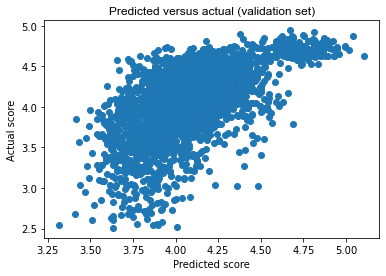

In [357]:
fig, ax = plt.subplots()
plt.scatter(y_pred2,y_val2)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

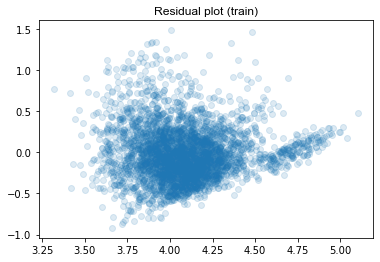

In [358]:
plt.scatter(check2['pred'],check2['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);

In [359]:
small_cluster_df = check2[check2['pred'] >= 4.5]

In [360]:
check2.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,3315,3315,3315,3315,3315,3315,3315,3315,3315,3315,3315,3315,3315,3315
1,201,201,201,201,201,201,201,201,201,201,201,201,201,201


In [361]:
small_cluster_df.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,45,45,45,45,45,45,45,45,45,45,45,45,45,45
1,183,183,183,183,183,183,183,183,183,183,183,183,183,183


In [362]:
check2.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
20272,5214.0,1,0,Finance,0,Everyone,2011,0,282.645562,1,0,-0.012371,2.518164,4.006745,1.488580
15801,2951.0,1,1,Entertainment,0,Everyone,2014,0,423.011844,259,0,0.757395,3.020270,4.481477,1.461207
1123,10019.0,1,0,Tools,0,Everyone,2012,0,321.750322,728,0,0.036445,2.546361,3.895302,1.348941
7663,5963.0,1,0,Arcade,0,Everyone,2013,0,351.370344,747,1,0.051748,2.575251,3.918434,1.343183
13822,10357.0,1,0,Books & Reference,0,Everyone,2011,0,283.848992,22,0,-0.073546,2.553640,3.888327,1.334687
16169,1940.0,1,0,Education,0,Everyone,2017,0,678.886626,469,0,0.593195,3.025773,4.360122,1.334349
6421,2151.0,1,1,Tools,0,Teen,2017,0,687.757909,130,0,0.076110,2.543779,3.866772,1.322993
21604,13748.0,1,0,Entertainment,0,Everyone,2011,0,280.112045,544,1,0.144356,2.723312,3.977836,1.254525
13982,12119.0,1,1,Finance,0,Everyone,2016,0,608.272506,168,0,-0.084533,2.620803,3.829221,1.208419
22127,10618.0,1,1,Tools,0,Everyone,2012,0,322.372663,1637,0,-0.007044,2.562030,3.770347,1.208317


## Testing with specific columns for genre - all apps

In [363]:
df_3 = df.copy()

In [364]:
df_3['action'] = np.where(df_3['genre'] == 'Action',1,0)
df_3['book_ref'] = np.where(df_3['genre'] == 'Books & Reference',1,0)
df_3['business'] = np.where(df_3['genre'] == 'Business',1,0)
df_3['card'] = np.where(df_3['genre'] == 'Card',1,0)
df_3['casino'] = np.where(df_3['genre'] == 'Casino',1,0)
df_3['comics'] = np.where(df_3['genre'] == 'Comics',1,0)
df_3['dating'] = np.where(df_3['genre'] == 'Dating',1,0)
df_3['education'] = np.where(df_3['genre'] == 'Education',1,0)
df_3['finance'] = np.where(df_3['genre'] == 'Finance',1,0)
df_3['food_drink'] = np.where(df_3['genre'] == 'Food & Drink',1,0)
df_3['health_fit'] = np.where(df_3['genre'] == 'Health & Fitness',1,0)
df_3['lib_demo'] = np.where(df_3['genre'] == 'Libraries & Demo',1,0)
df_3['puzzle'] = np.where(df_3['genre'] == 'Puzzle',1,0)
df_3['simulation'] = np.where(df_3['genre'] == 'Simulation',1,0)
df_3['weather'] = np.where(df_3['genre'] == 'Weather',1,0)
df_3['word'] = np.where(df_3['genre'] == 'Word',1,0)
df_3['vid_edit'] = np.where(df_3['genre'] == 'Video Players & Editors',1,0)

In [365]:
X3 = df_3[['ratings','free','containsAds','editorsChoice','contentRating','year','top_developer','installs_day',
           'updated_days','has_video','compound',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

y3 = df_3['score']

In [366]:
# Split to create temporary tr and test 
X_tr3, X_test3, y_tr3, y_test3 = train_test_split(X3, y3,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_tr3, y_tr3,test_size=.20, random_state=10)

In [367]:
X_train_cont3 = X_train3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

X_val_cont3 = X_val3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

In [368]:
ohe3 = OneHotEncoder(drop='first', sparse=False)

ohe3.fit(X_train3[['contentRating']])

ohe_x_train3 = ohe3.transform(X_train3[['contentRating']])

columns3 = ohe3.get_feature_names(['contentRating'])

ohe_x_train_df3 = pd.DataFrame(ohe_x_train3, columns=columns3, index=X_train3.index)

In [369]:
ohe_v3 = OneHotEncoder(drop='first', sparse=False)

ohe_v3.fit(X_val3[['contentRating']])

ohe_x_val3 = ohe_v3.transform(X_val3[['contentRating']])

columns_v3 = ohe_v3.get_feature_names(['contentRating'])

ohe_x_val_df3 = pd.DataFrame(ohe_x_val3, columns=columns_v3, index=X_val3.index)

In [370]:
#Merge cont and cat DFs
combo_train_df3 = pd.concat([X_train_cont3, ohe_x_train_df3], axis=1)

combo_val_df3 =  pd.concat([X_val_cont3, ohe_x_val_df3], axis=1)

In [371]:
combo_val_df3

,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,action,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen
14771,1,1,0,2019,0,2217.294900,30,0,0.302064,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
1571,1,1,0,2016,0,570.776256,1625,1,0.302643,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
15290,1,0,0,2016,0,636.942675,55,1,0.116115,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1730,1,1,0,2013,0,337.952011,36,1,0.094496,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
12745,1,1,0,2014,0,421.229992,873,0,0.160532,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16021,1,1,0,2018,0,1021.450460,27,1,0.244804,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
6807,1,1,0,2017,0,830.564784,358,0,0.052979,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
12383,1,1,0,2018,0,1152.073733,161,1,0.617721,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
21184,1,1,0,2015,0,497.760080,160,0,0.103150,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [372]:
lr3 = LinearRegression()

lr3.fit(combo_train_df3, y_train3)

y_pred3 = lr3.predict(combo_val_df3)
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(combo_val_df3, y_val3)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val3, y_pred3))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.36


In [373]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df3.columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
containsAds : -0.03
editorsChoice : 0.13
year : -0.02
top_developer : 0.47
installs_day : 0.00
updated_days : -0.00
has_video : 0.06
compound : 1.14
action : 0.01
book_ref : 0.09
business : 0.11
card : 0.19
casino : 0.23
comics : -0.09
dating : -0.04
education : -0.01
finance : 0.09
food_drink : 0.15
health_fit : 0.09
lib_demo : 0.01
puzzle : 0.12
simulation : -0.09
weather : -0.00
word : 0.20
vid_edit : -0.08
contentRating_Everyone 10+ : 0.03
contentRating_Mature 17+ : -0.00
contentRating_Teen : -0.03


In [374]:
check3 = X_val3.copy()
check3['score'] = y_val3
check3['pred'] = lr3.predict(combo_val_df3)
check3['resid'] = check3['pred'] - check3['score']

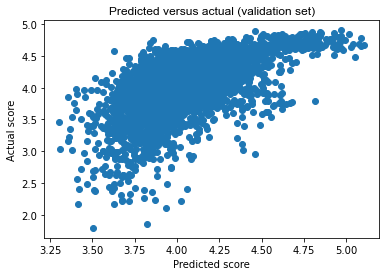

In [375]:
fig, ax = plt.subplots()
plt.scatter(y_pred3,y_val3)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

In [376]:
check3.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,score,pred,resid
10136,17466.0,1,1,0,Everyone,2010,0,265.816055,362,0,...,0,0,0,0,0,0,0,1.850772,3.824589,1.973817
1321,22315.0,1,1,0,Everyone,2010,0,266.311585,75,0,...,0,0,0,0,0,0,0,2.106250,3.937326,1.831076
19530,3864.0,1,0,0,Teen,2015,0,490.436488,30,1,...,0,0,0,0,0,0,0,2.216495,4.023877,1.807382
7644,6727.0,1,1,0,Everyone,2014,0,389.559797,15,0,...,0,0,0,0,0,0,0,1.794643,3.505112,1.710469
13595,41818.0,1,1,0,Teen,2013,0,344.946533,7,0,...,0,0,0,0,0,0,0,2.405864,4.061389,1.655525
10562,6694.0,1,0,0,Everyone,2012,0,331.785003,507,0,...,0,0,0,0,0,0,0,2.231689,3.871938,1.640249
1394,16883.0,1,1,0,Everyone,2019,0,1519.756839,23,1,...,0,0,0,0,0,0,0,2.269458,3.806288,1.536830
1362,15063.0,1,0,0,Everyone,2015,0,450.045005,726,0,...,0,0,0,0,0,0,0,2.213104,3.714207,1.501103
20743,3593.0,1,1,0,Everyone,2020,0,2932.551320,290,0,...,0,0,0,0,0,0,0,2.961111,4.459302,1.498191
12341,14008.0,1,0,0,Everyone,2010,0,264.620270,6,0,...,0,0,0,0,0,0,0,2.358464,3.852988,1.494524


## with transformed target

In [377]:
from scipy.stats import boxcox

In [378]:
X4 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

bcx_target,lam =boxcox(df_copy['score'])

In [379]:
len(bcx_target)

21970

In [380]:
# Split to create temporary tr and test 
X_tr4, X_test4, y_tr4, y_test4 = train_test_split(X4, bcx_target,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_tr4, y_tr4,test_size=.20, random_state=10)

In [381]:
X_train_cont4 = X_train4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont4 = X_val4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [382]:
ohe4 = OneHotEncoder(drop='first', sparse=False)

ohe4.fit(X_train4[['genre','contentRating']])

ohe_x_train4 = ohe4.transform(X_train4[['genre','contentRating']])

columns4 = ohe4.get_feature_names(['genre','contentRating'])

ohe_x_train_df4 = pd.DataFrame(ohe_x_train4, columns=columns4, index=X_train4.index)

In [383]:
ohe_v4 = OneHotEncoder(drop='first', sparse=False)

ohe_v4.fit(X_val4[['genre','contentRating']])

ohe_x_val4 = ohe_v4.transform(X_val4[['genre','contentRating']])

columns_v4 = ohe_v4.get_feature_names(['genre','contentRating'])

ohe_x_val_df4 = pd.DataFrame(ohe_x_val4, columns=columns_v4, index=X_val4.index)

In [384]:
#Merge cont and cat DFs
combo_train_df4 = pd.concat([X_train_cont4, ohe_x_train_df4], axis=1)

combo_val_df4 =  pd.concat([X_val_cont4, ohe_x_val_df4], axis=1)

In [385]:
lr4 = LinearRegression()

lr4.fit(combo_train_df4, y_train4)

y_pred4 = lr4.predict(combo_val_df4)
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(combo_val_df4, y_val4)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val4, y_pred4))))

R^2 of linear regression on val set: 0.42
MSE of linear regression on val set: 12.32


In [386]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df4.columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -4.83
containsAds : -1.34
editorsChoice : 6.85
year : -0.55
top_developer : 23.89
installs_day : 0.00
updated_days : -0.00
has_video : 2.65
compound : 37.96
genre_Adventure : -3.27
genre_Arcade : 1.35
genre_Art & Design : 1.81
genre_Auto & Vehicles : 3.65
genre_Beauty : -3.91
genre_Board : 3.98
genre_Books & Reference : 6.29
genre_Business : 6.17
genre_Card : 8.79
genre_Casino : 9.57
genre_Casual : -0.36
genre_Comics : -3.16
genre_Communication : 3.66
genre_Dating : 2.06
genre_Education : 1.34
genre_Entertainment : -1.17
genre_Events : -3.61
genre_Finance : 8.15
genre_Food & Drink : 4.87
genre_Health & Fitness : 5.67
genre_House & Home : 5.80
genre_Libraries & Demo : -3.01
genre_Lifestyle : 1.32
genre_Maps & Navigation : 5.00
genre_Medical : 1.77
genre_Music : 1.13
genre_Music & Audio : 3.75
genre_News & Magazines : 3.33
genre_Parenting : 4.26
genre_Personalization : 4.13
genre_Photography : -1.03
genre_Productivity : 3.71
genre_Puzzle : 6.10
genre

In [387]:
check4 = X_val4.copy()
check4['score'] = y_val4
check4['pred'] = lr4.predict(combo_val_df4)
check4['resid'] = check4['pred'] - check4['score']

In [388]:
check4.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
15801,2951.0,1,1,Entertainment,0,Everyone,2014,0,423.011844,259,0,0.757395,15.254889,62.895751,47.640862
16169,1940.0,1,0,Education,0,Everyone,2017,0,678.886626,469,0,0.593195,15.358509,58.619004,43.260495
16703,3080.0,1,1,Role Playing,0,Everyone 10+,2018,0,970.873786,160,1,0.698698,23.728652,63.366166,39.637514
20272,5214.0,1,0,Finance,0,Everyone,2011,0,282.645562,1,0,-0.012371,7.718131,46.451956,38.733825
3603,2705.0,1,1,Racing,0,Everyone,2017,0,808.407437,113,0,0.668262,20.555365,58.840984,38.285619
17233,8905.0,1,1,Casual,0,Everyone,2019,0,2262.443439,441,0,0.524947,15.611643,53.381098,37.769454
476,10825.0,1,1,Food & Drink,0,Teen,2017,0,736.377025,134,0,0.855825,35.224614,71.194352,35.969738
4224,13840.0,1,0,Social,0,Everyone,2013,0,342.700480,464,1,0.147186,13.007965,48.398285,35.390319
3868,2056.0,1,1,Travel & Local,0,Everyone,2018,0,1160.092807,749,1,0.615620,25.333580,60.240833,34.907253
7468,3469.0,1,1,Communication,0,Mature 17+,2016,0,618.811881,590,0,0.725034,29.525907,64.264231,34.738324


In [389]:
check4[(check4['resid'] >= -0.1) & (check4['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
14113,9971.0,1,1,Entertainment,0,Teen,2015,0,497.017893,7,0,-0.029583,32.685420,32.726263,0.040843
14840,26627.0,1,1,Books & Reference,0,Everyone,2012,0,302.114804,190,0,0.581728,64.926646,64.839343,-0.087303
111,25872.0,1,0,Health & Fitness,0,Everyone,2016,1,654.450262,1,1,0.318646,80.726309,80.642329,-0.083980
14517,24481.0,1,1,Personalization,0,Everyone,2013,0,355.745286,1500,1,0.324373,52.117172,52.139673,0.022502
11560,100768.0,1,0,Role Playing,0,Teen,2015,0,523.012552,9,1,0.262078,47.227234,47.292840,0.065607
17274,27971.0,1,1,Video Players & Editors,0,Everyone,2015,0,508.905852,22,0,0.339906,47.173744,47.234966,0.061222
3080,12495.0,1,1,Productivity,0,Everyone,2010,0,247.708695,1616,1,0.430465,57.128449,57.049971,-0.078478
20354,8611.0,1,1,Video Players & Editors,0,Everyone,2015,0,446.030330,102,0,0.149575,39.863109,39.775109,-0.088000
17644,9370.0,1,1,Card,0,Teen,2016,0,635.324015,23,1,0.264503,56.084484,56.035608,-0.048875
11060,7593.0,1,1,Simulation,0,Everyone,2016,0,557.724484,388,0,0.388800,46.259121,46.280275,0.021154


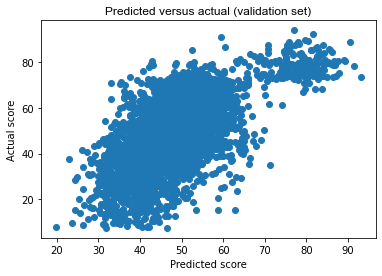

In [390]:
fig, ax = plt.subplots()
plt.scatter(y_pred4,y_val4)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

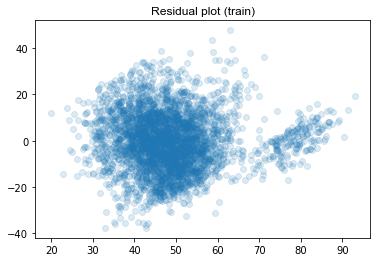

In [391]:
plt.scatter(check4['pred'],check4['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);